# Set-up

In [1]:
#Check directory
!pwd

/Users/georgesmith/Desktop/RTP/Season 28/Development/Analysis


In [2]:
#Change directory
%cd /Users/georgesmith/Desktop/RTP/Season 28/Development/Analysis/

/Users/georgesmith/Desktop/RTP/Season 28/Development/Analysis


In [3]:
#Import necessary packages:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
import plotly.graph_objects as go # To Generate Graphs
import plotly.express as px # To Generate box plot for statistical representation
#import itertools
#import sys
#Install pingouin package into this jupyter kernal
#!{sys.executable} -m pip install pingouin
#import pingouin as pg #this throws the warning message
#!{sys.executable} -m pip install --upgrade statsmodels
#import pickle
# import plotly.offline as py
# color = sns.color_palette()
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
# import plotly.tools as tls


%matplotlib inline

In [4]:
#Import and prep data

#Read in donation data:
input_cols = ['account_id',
 'account_name',
 'contact_name',
 'account_record_type',
 'do_not_mail',
 'donation_record_type',
 'informal_salutation',
 'amount',
 'close_date',
 'email_opt_out',
 'contact_email',
 'mailing_street',
 'mailing_city',
 'mailing_state',
 'mailing_zip',
 'fund',
 'frequency',
 'payment_type',
 'pledge_amount',
 'payment_schedule',
 'type',
 'stage',
 'fiscal_year',
 'fiscal_quarter',
 'last_donation_amount',
 'last_donation_date',
 'close_month',
 'anonymous',
 'card_type',
 'check_date',
 'donation_matched',
 'grant_amount',
 'matching_amount',
 'matching_close_date',
 'first_donation_date',
 'lifetime_donation_total_amount',
 'lifetime_donation_count',
 'lifetime_subscription_purchase_total',
 'lifetime_single_ticket_purchase_total',
 'lifetime_order_count']
 
raw_donations = pd.read_csv('/Users/georgesmith/Desktop/RTP/Season 28/Development/Analysis/donations_Jul2014_Jan202021.csv', header=0, names=input_cols)

#Drop identifying columns to anonymize data (and the entirely null 'donation_matched' and 'matching_close_date' columns)
iden_cols = ['account_name', 'contact_name', 'informal_salutation', 'donation_matched', 'matching_close_date', 'contact_email', 'mailing_street']
donations = raw_donations.drop(iden_cols, axis=1, inplace=False)
donations.head()

,account_id,account_record_type,do_not_mail,donation_record_type,amount,close_date,email_opt_out,mailing_city,mailing_state,mailing_zip,...,card_type,check_date,grant_amount,matching_amount,first_donation_date,lifetime_donation_total_amount,lifetime_donation_count,lifetime_subscription_purchase_total,lifetime_single_ticket_purchase_total,lifetime_order_count
0,NaN,NaN,0,Donation,25.0,1/20/21,0,East Kingston,NH,3827,...,Discover,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0013p000020Q9Em,Individual,0,PatronTicket Donation,13.0,9/26/20,0,Hardy,VA,24101,...,MasterCard,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,0011R00002HkvI7,Individual,0,Donation,50.0,5/22/20,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
3,0013600000TKzRp,Individual,0,Donation,1.0,10/31/18,0,New York,NY,10019,...,Amex,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
4,0013600000TKzRp,Individual,0,Donation,1.0,8/10/16,0,New York,NY,10019,...,Amex,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [5]:
def col_dtype_conversions(df, col_list1, new_dtype1, col_list2, new_dtype2):
    """
    Converts columns in col_list1 to datatype specified in new_dtype1
    and converts those in col_list2 to datatype specified in new_dtype2

    Params
    ------
    df : pandas.DataFrame
        dataframe with columns in both col_lists
    col_list1 : list
        list of column names to be converted to dtype specified by new_dtype1
    new_dtype1 : str (must put in quotes)
        data type to which columns in col_list1 will be converted
    col_list2 : list
        list of column names to be converted to dtype specified by new_dtype2
    new_dtype2 : str (must put in quotes)
        data type to which columns in col_list2 will be converted

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns, some of which are now cast as
        the specified data types
    """
    for col1 in col_list1:
        df[col1] = df[col1].astype(new_dtype1)
        for col2 in col_list2:
            df[col2] = df[col2].astype(new_dtype2)
    return

col1 = ['fiscal_year', 'do_not_mail', 'email_opt_out', 'anonymous']
col2 = ['close_date', 'close_month', 'first_donation_date', 'last_donation_date', 'check_date']

col_dtype_conversions(donations, col1, 'str', col2, 'datetime64[ns]')

In [6]:
#Parse month from full dates shown in close_month column
donations.close_month = donations.close_month.dt.month.astype('str')

In [7]:
#Donations with missing values in the fund column are Annual Fund gifts made online -- reassign accordingly
donations.fund.fillna('Annual Fund', inplace=True)

#Consolidate all Annual Fund donations under a common string
donations.fund = np.where(donations.fund.isin(['ANN', 'Annual Fund Historical']), 'Annual Fund', donations.fund)

#Group levels referencing the same fund under common levels
donations.loc[(donations['fund'].isin(["25th Anniversary Campaign Fund", '25th Anniversary Fund', '25TH'])), 'fund'] = "25th Anniversary Capital Campaign"
donations.loc[(donations['fund'] == 'NEXT'), 'fund'] = "Next Stage Campaign"
donations.loc[(donations['fund'] == 'John Knapp -Tim Gillham Fund'), 'fund'] = "New Works (Knapp-Gillham) Fund"
donations.loc[(donations['fund'].isin(["Education Program Fund", 'EDUC'])), 'fund'] = "Education Fund"
donations.loc[(donations['fund'] == 'MMP'), 'fund'] = "Mary Morton Parsons Challenge Grant Match"

#Reviewed cleaned fund column distribution
donations.fund.value_counts(dropna=False)

Annual Fund                                  4540
25th Anniversary Capital Campaign              94
Next Stage Campaign                            82
Advertiser                                     73
Education Fund                                 34
Sponsorship Fund                               24
Mary Morton Parsons Challenge Grant Match      11
Moose Management Academy Attendance             8
Project Fund                                    8
New Works (Knapp-Gillham) Fund                  8
Building Fund                                   6
So.Queer Playwrights Festival                   2
Cabell Foundation Match                         1
Name: fund, dtype: int64

In [8]:
donations = donations[donations['account_record_type'].isin(['Individual', 'Household'])].reset_index(drop=True)
donations.head()

,account_id,account_record_type,do_not_mail,donation_record_type,amount,close_date,email_opt_out,mailing_city,mailing_state,mailing_zip,...,card_type,check_date,grant_amount,matching_amount,first_donation_date,lifetime_donation_total_amount,lifetime_donation_count,lifetime_subscription_purchase_total,lifetime_single_ticket_purchase_total,lifetime_order_count
0,0013p000020Q9Em,Individual,0,PatronTicket Donation,13.0,2020-09-26,0,Hardy,VA,24101,...,MasterCard,NaT,NaN,0.0,NaT,0.0,0.0,0.0,0.0,0.0
1,0011R00002HkvI7,Individual,0,Donation,50.0,2020-05-22,0,NaN,NaN,NaN,...,NaN,NaT,NaN,0.0,NaT,0.0,0.0,0.0,0.0,0.0
2,0013600000TKzRp,Individual,0,Donation,1.0,2018-10-31,0,New York,NY,10019,...,Amex,NaT,NaN,0.0,NaT,0.0,0.0,0.0,0.0,0.0
3,0013600000TKzRp,Individual,0,Donation,1.0,2016-08-10,0,New York,NY,10019,...,Amex,NaT,NaN,0.0,NaT,0.0,0.0,0.0,0.0,0.0
4,0011R00001zaq0m,Household,0,Donation,25.0,2020-06-15,0,Quinton,VA,23141-2209,...,NaN,2020-06-09,NaN,0.0,2020-06-15,25.0,1.0,0.0,184.5,2.0


Executive Director tells me this is, in fact, an individual donor's annual fund donation, which is correctly designated as a grant because it comes from their family advised fund.

In [9]:
#Reassign this record to annual fund donation (i.e. change donation_record_type to Donation & amount to $100)
donations.loc[(donations.account_id == '0013600000ggdlM'), 'last_donation_date'] = '2020-12-21'
donations.loc[(donations.account_id == '0013600000ggdlM'), 'last_donation_amount'] = 100
donations.loc[(donations.account_id == '0013600000ggdlM') & (donations.close_date == '2020-12-21'), 'donation_record_type'] = 'Donation'
donations.loc[(donations.account_id == '0013600000ggdlM') & (donations.close_date == '2020-12-21'), 'amount'] = 100

In [10]:
#Assign group levels referencing the same payment_type to common levels
donations.loc[(donations['payment_type'] == 'CRED'), 'payment_type'] = "Credit Card"
donations.loc[(donations['payment_type'] == 'Third Party'), 'payment_type'] = "Credit Card - Third Party"
donations.loc[(donations['payment_type'] == 'INKND'), 'payment_type'] = "In Kind"
donations.loc[(donations['payment_type'].isna()) & donations['check_date'].notnull(), 'payment_type'] = "Check"

In [11]:
donations.loc[donations.payment_type.isna()].sort_values('close_date')

,account_id,account_record_type,do_not_mail,donation_record_type,amount,close_date,email_opt_out,mailing_city,mailing_state,mailing_zip,...,card_type,check_date,grant_amount,matching_amount,first_donation_date,lifetime_donation_total_amount,lifetime_donation_count,lifetime_subscription_purchase_total,lifetime_single_ticket_purchase_total,lifetime_order_count
4471,0013600000VKQmI,Household,0,Pledge,NaN,2015-02-04,0,Richmond,VA,23222,...,Visa,NaT,NaN,0.0,2009-05-01,10023.35,77.0,1280.0,3963.25,67.0
4472,0013600000VKQmI,Household,0,Pledge,NaN,2015-02-04,0,Richmond,VA,23222,...,Visa,NaT,NaN,0.0,2009-05-01,10023.35,77.0,1280.0,3963.25,67.0
4668,0013600000VKQlO,Individual,0,Pledge Payment,125.0,2015-03-19,0,Richmond,VA,23225-3502,...,NaN,NaT,NaN,0.0,2009-10-21,22182.67,138.0,300.0,2164.00,22.0
3282,0013600000VKQoW,Household,0,Pledge,NaN,2015-03-19,0,NaN,NaN,NaN,...,Visa,NaT,NaN,0.0,2012-09-15,6965.00,14.0,1110.0,1368.00,13.0
3283,0013600000VKQoW,Household,0,Pledge,NaN,2015-03-19,0,NaN,NaN,NaN,...,Visa,NaT,NaN,0.0,2012-09-15,6965.00,14.0,1110.0,1368.00,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4455,0013600000VKQmI,Household,0,Pledge,NaN,2020-04-27,0,Richmond,VA,23222,...,Visa,NaT,NaN,0.0,2009-05-01,10023.35,77.0,1280.0,3963.25,67.0
4498,0013600000VKQmI,Household,0,Pledge,NaN,2020-05-16,0,Richmond,VA,23222,...,Visa,NaT,NaN,0.0,2009-05-01,10023.35,77.0,1280.0,3963.25,67.0
4500,0013600000VKQmI,Household,0,Pledge,NaN,2020-05-16,0,Richmond,VA,23222,...,Visa,NaT,NaN,0.0,2009-05-01,10023.35,77.0,1280.0,3963.25,67.0
4488,0013600000VKQmI,Household,0,Pledge,NaN,2020-11-03,0,Richmond,VA,23222,...,Visa,NaT,NaN,0.0,2009-05-01,10023.35,77.0,1280.0,3963.25,67.0


In [12]:
#Assign the remaining records to check
donations.loc[donations['payment_type'].isna(), 'payment_type'] = "Check"

In [13]:
#Select donations where close_date > '2015-07-01'
donations = donations[donations.close_date > '2015-06-30']

In [14]:
#Subset the pledge records from the actual donations
pledges = donations[donations.donation_record_type == 'Pledge']

In [15]:
#Select only donations applicable to stewardship program (i.e. hh or individual account record type; fund == annual fund; 
#donation records type isin(['Donation', 'PatronTicket Donation', 'Pledge Payment', 'Grant', 'Matching Donation']))
donations = donations[donations.donation_record_type.isin(['Donation', 'PatronTicket Donation', 'Pledge Payment', 'Grant', 'Matching Donation'])]

In [16]:
#Filter out the donation record(s) id-ed above where amount is nan
donations = donations[donations.amount.notnull()].reset_index(drop=True)

In [17]:
#Remove PatronManager Client Services records from analysis (i.e account_id == '0013600000TKzRp')
donations = donations[donations.account_id != '0013600000TKzRp']

**Segment Annual Fund**

In [18]:
aFund = donations.loc[donations.fund == 'Annual Fund', :].copy().reset_index(drop=True)

#Remove the In Kind donations as they are not driven by campaigns that raise money for the annual fund:
aFund = aFund[aFund.payment_type != 'In Kind']

In [21]:
aFund.groupby('close_date')['account_id'].size()

close_date
2015-07-09    3
2015-07-14    3
2015-08-03    4
2015-08-10    2
2015-08-11    1
             ..
2021-01-16    5
2021-01-17    2
2021-01-18    3
2021-01-19    2
2021-01-20    2
Name: account_id, Length: 1024, dtype: int64

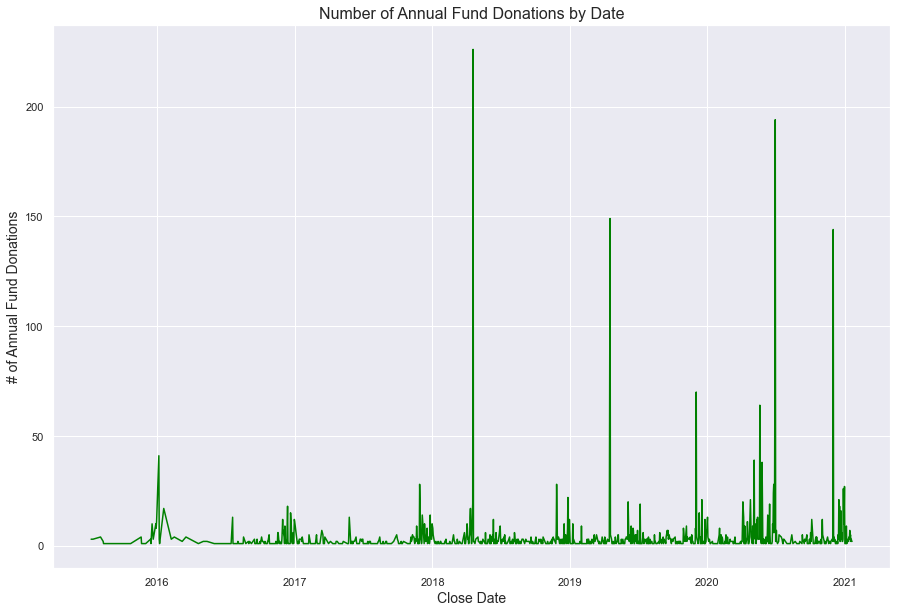

In [28]:
#Plot the daily annual fund donation totals

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,10])

#Line Plot
sns.lineplot(x=aFund.groupby('close_date')['account_id'].size().index, y=aFund.groupby('close_date')['account_id'].size().values, color='green')

#Assign axis labels:
plt.ylabel('# of Annual Fund Donations', fontsize=14)
plt.xlabel('Close Date', fontsize=14)
plt.title('Number of Annual Fund Donations by Date', fontsize=16)
plt.show()

In [27]:
aFund.groupby('close_date')['account_id'].size().sort_values(ascending=False)

close_date
2018-04-19    226
2020-06-30    194
2019-04-18    149
2020-12-01    144
2020-06-29     77
             ... 
2019-11-26      1
2019-11-25      1
2019-11-20      1
2018-04-07      1
2019-01-02      1
Name: account_id, Length: 1024, dtype: int64

**4 of the 5 days with the highest annual fund donation volume have been within the past 1.5 years.**

In [32]:
aFund['close_year'] = aFund.close_date.dt.year
aFund['close_year'].value_counts()

2020    1475
2019     917
2018     867
2017     412
2016     334
2015      68
2021      54
Name: close_year, dtype: int64

In [33]:
aFund['close_month'] = aFund.close_date.dt.month
aFund['close_month'].value_counts()

12    881
6     661
4     656
5     426
11    329
1     239
7     185
9     176
10    169
2     148
8     145
3     112
Name: close_month, dtype: int64

In [63]:
aFundDons_by_close_month = aFund.groupby(['close_year', 'close_month']).size().reset_index()
aFundDons_by_close_month.columns = ['close_year', 'close_month', '# of donations']
aFundDons_by_close_month.head()

,close_year,close_month,# of donations
0,2015,7,6
1,2015,8,7
2,2015,9,2
3,2015,10,1
4,2015,11,5


In [44]:
aFundDons_by_close_month['close_year'].value_counts()

2020    12
2019    12
2018    12
2017    12
2016    11
2015     6
2021     1
Name: close_year, dtype: int64

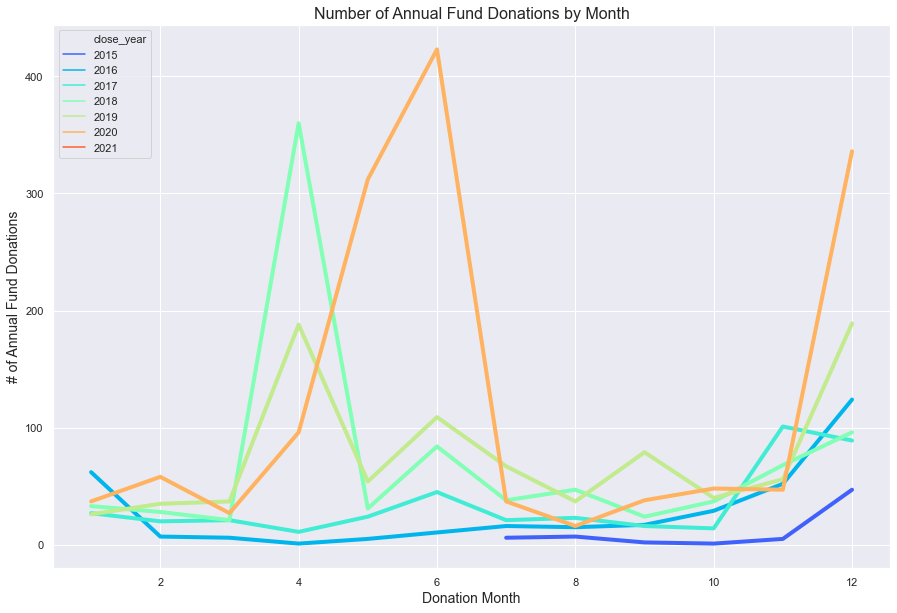

In [67]:
#Plot the daily annual fund donation totals

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,10])

#Line Plot
sns.lineplot(x='close_month', y='# of donations', hue=aFundDons_by_close_month['close_year'].astype('category'),
             hue_order=[2015, 2016, 2017, 2018, 2019, 2020, 2021],
             palette='rainbow', lw=4,
             data=aFundDons_by_close_month)

#Assign axis labels:
plt.ylabel('# of Annual Fund Donations', fontsize=14)
plt.xlabel('Donation Month', fontsize=14)
plt.title('Number of Annual Fund Donations by Month', fontsize=16)
plt.show()

In [37]:
aFund.groupby(['close_year', 'close_month'])['account_id'].count().reset_index()

,close_year,close_month,account_id
0,2015,7,6
1,2015,8,7
2,2015,9,2
3,2015,10,1
4,2015,11,5
...,...,...,...
61,2020,9,38
62,2020,10,48
63,2020,11,47
64,2020,12,336


In [70]:
#How many donations did each account make over this review period?
donor_gifts = aFund.groupby(['account_id']).size().reset_index()
donor_gifts.columns = ['account_id', 'num_donations']
donor_gifts.head()

,account_id,num_donations
0,0011R00001yzm4S,1
1,0011R00001zaq0m,1
2,0011R00001zbJNc,2
3,0011R00001zbJO4,1
4,0011R00001zcCFw,1


Text(0.5, 1.0, 'Annual Fund Donation Counts By Donor')

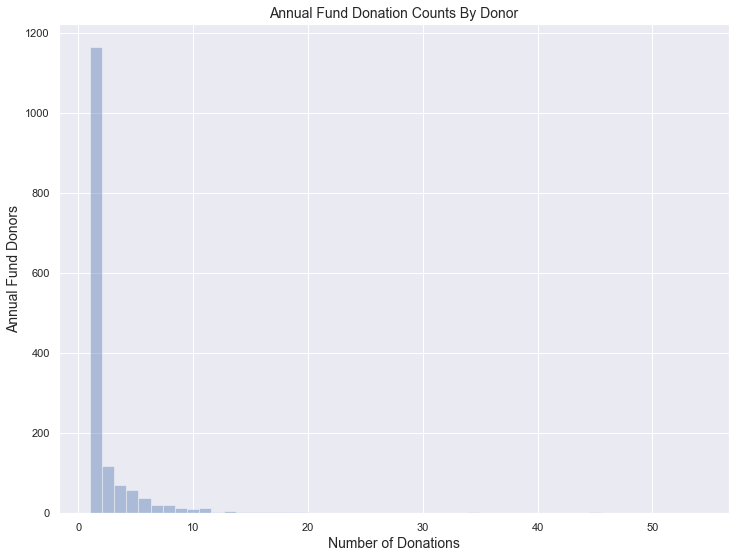

In [71]:
#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[12,9])

sns.distplot(donor_gifts.num_donations, kde=False)

#Assign axis labels:
plt.xlabel('Number of Donations', fontsize=14)
plt.ylabel('Annual Fund Donors', fontsize=14)
#plt.xticks(rotation=45)
plt.title('Annual Fund Donation Counts By Donor', fontsize=14)

# Binary Classification Model

**We'll build a model to predict whether a donor will give in the coming six month period.**

*As such, we'll split the data on close_date field to create the model_window (including all donations between 2015-07-01 and the snapshot date of 2020-06-30) as well as the prediction window, which includes all donations made between 2020-07-01 and 2020-12-31.*

In [111]:
snapshot_date = pd.to_datetime('2020-06-30')

In [112]:
snapshot_date

Timestamp('2020-06-30 00:00:00')

In [113]:
#aFund['close_date'] = aFund['close_date'].astype('datetime64[ns]')
aFund['close_date'] = pd.to_datetime(aFund['close_date'].astype('str'))

In [114]:
#Filter the data to create the modeling window for analysis
model_window = aFund.loc[aFund['close_date'] <= snapshot_date].reset_index()

len(aFund), len(model_window)

(4127, 3551)

In [115]:
#Filter out donations made after 2020-12-31 so that the prediction window is limited to the 6-month interval
aFund_filtered = aFund.loc[aFund['close_date'] <= pd.to_datetime('2020-12-31')].sort_values('close_date', ascending=False).reset_index()

In [116]:
len(aFund_filtered), len(model_window)

(4073, 3551)

In [117]:
#Confirm accuracy of start and end dates for aFund_filtered
aFund_filtered.close_date.max(), aFund_filtered.close_date.min()

(Timestamp('2020-12-31 00:00:00'), Timestamp('2015-07-09 00:00:00'))

In [118]:
#Confirm accuracy of start and end dates for aFund_filtered
model_window.close_date.max(), model_window.close_date.min()

(Timestamp('2020-06-30 00:00:00'), Timestamp('2015-07-09 00:00:00'))

# Feature engineering

Extract the most recent donation by each unique donor account in order to calculate donor recency (number of days between beginning of period and the snapshot date)

**Feature #1: donor_recency**

In [119]:
#Get max date for each accounts' donation
donor_recency = model_window.groupby('account_id')['close_date'].max().reset_index()
donor_recency.head()

,account_id,close_date
0,0011R00001yzm4S,2018-10-20
1,0011R00001zaq0m,2020-06-15
2,0011R00001zbJO4,2019-04-18
3,0011R0000203w1Q,2019-02-23
4,0011R000020JELD,2018-11-13


In [120]:
#Count number of days between donor_recency date and the snapshot date
#donor_recency['close_date'] = pd.to_datetime(donor_recency['close_date'].astype('str'))
delta = snapshot_date - donor_recency['close_date']
delta.head()

0   619 days
1    15 days
2   439 days
3   493 days
4   595 days
Name: close_date, dtype: timedelta64[ns]

In [121]:
#Convert this timedelta feature into an integer field inside the donor_recency df
donor_recency['donation_recency'] = delta.dt.days
donor_recency.head()

,account_id,close_date,donation_recency
0,0011R00001yzm4S,2018-10-20,619
1,0011R00001zaq0m,2020-06-15,15
2,0011R00001zbJO4,2019-04-18,439
3,0011R0000203w1Q,2019-02-23,493
4,0011R000020JELD,2018-11-13,595


In [122]:
#Drop the close_date from this df since we're finished with it here
donor_recency.drop('close_date', axis=1, inplace=True)

In [123]:
donor_recency.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
account_id,1436,1436,0013600000Xsazj,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
donation_recency,1436,NaN,NaN,NaN,382.496,447.551,0,15,200.5,678.5,1818


Among other stats, this summary shows that 1436 donors are included in the modeling dataset for this time period.

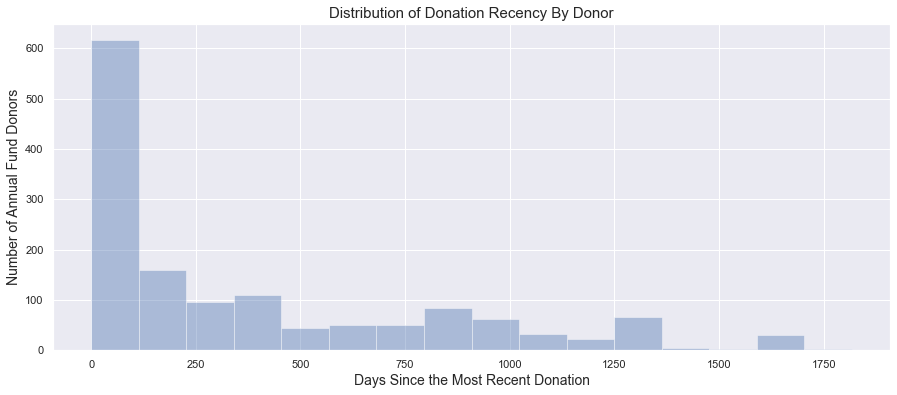

In [125]:
#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure().set_size_inches(15,6)

sns.distplot(donor_recency['donation_recency'], kde=False)

#Assign axis labels:
plt.xlabel('Days Since the Most Recent Donation', fontsize=14)
plt.ylabel('Number of Annual Fund Donors', fontsize=14)
#plt.xticks(rotation=45)
plt.title('Distribution of Donation Recency By Donor', fontsize=15)
plt.show()

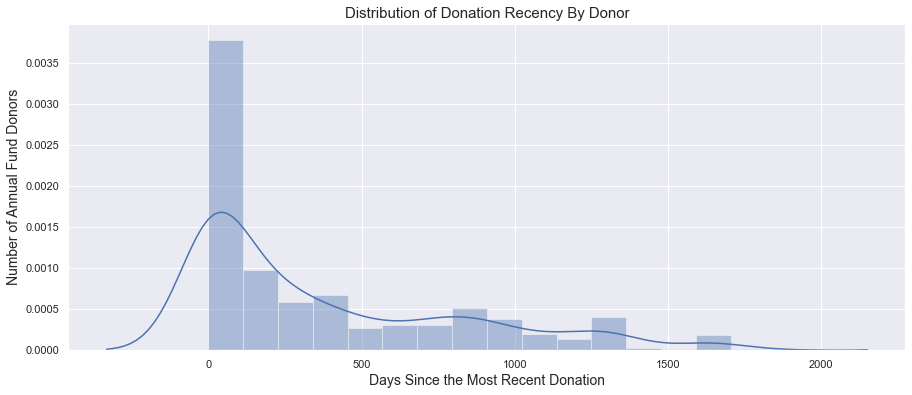

In [126]:
#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure().set_size_inches(15,6)

sns.distplot(donor_recency['donation_recency'], kde=True)

#Assign axis labels:
plt.xlabel('Days Since the Most Recent Donation', fontsize=14)
plt.ylabel('Number of Annual Fund Donors', fontsize=14)
#plt.xticks(rotation=45)
plt.title('Distribution of Donation Recency By Donor', fontsize=15)
plt.show()

In [129]:
#What are the low and high bounds of donation_recency
donor_recency['donation_recency'].min(), donor_recency['donation_recency'].max()

(0, 1818)

In [134]:
recency_distr = donor_recency.groupby('donation_recency').size().reset_index().rename(columns={0: 'donor_count'})
recency_distr.head()

,donation_recency,donor_count
0,0,184
1,1,73
2,2,13
3,3,6
4,4,27


In [144]:
cum_pctg = recency_distr['donor_count'].cumsum() / sum(recency_distr['donor_count'])
cum_pctg.head()

0    0.128134
1    0.178969
2    0.188022
3    0.192201
4    0.211003
Name: donor_count, dtype: float64

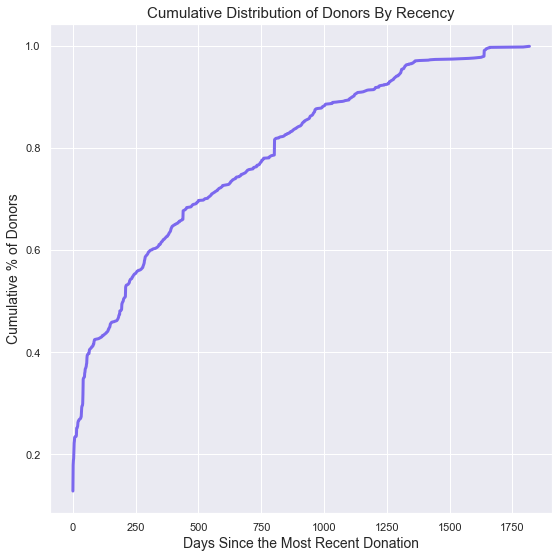

In [145]:
#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure().set_size_inches(9,9)

sns.lineplot(x=recency_distr['donation_recency'], y=cum_pctg, 
             color='mediumslateblue', lw=3)

#Assign axis labels:
plt.xlabel('Days Since the Most Recent Donation', fontsize=14)
plt.ylabel('Cumulative % of Donors', fontsize=14)
plt.title('Cumulative Distribution of Donors By Recency', fontsize=15)
plt.show()

May consider excluding from the modeling dataset donors who have not given in one/two/three/etc years; however, another consideration is ensuring we have as many observations as possible given the relatively small number of donors we have at this stage (1436)

**Feature #2: Number of Donations Per Donor/Account**

In [149]:
#Count number of donations per donor/account (in our analysis, account and donor are used interchangeably)
account_donations = model_window.groupby('account_id').size().reset_index().rename(columns={0: 'total_donations'})
account_donations.head()

,account_id,total_donations
0,0011R00001yzm4S,1
1,0011R00001zaq0m,1
2,0011R00001zbJO4,1
3,0011R0000203w1Q,1
4,0011R000020JELD,1


**Combine these attributes into a single dataframe**

In [152]:
attrs = pd.merge(donor_recency, account_donations, on='account_id', how='inner')
len(attrs)

1436

In [153]:
attrs.head()

,account_id,donation_recency,total_donations
0,0011R00001yzm4S,619,1
1,0011R00001zaq0m,15,1
2,0011R00001zbJO4,439,1
3,0011R0000203w1Q,493,1
4,0011R000020JELD,595,1


# Assign the Target Variable

**The objective of our initial model is to predict whether a donor account will make at least one donation in the future (within the models target window of 6 months).**

**Step 1:** Isolate all donations that were made within the prediction window

In [162]:
#Select annual fund donations made after June 30, 2020 (thru Dec 31, 2020, inclusive)
mask = (aFund.close_date > '2020-06-30') & (aFund.close_date < '2021-01-01')
target_events_raw = aFund[mask]
target_events_raw.head()

,account_id,account_record_type,do_not_mail,donation_record_type,amount,close_date,email_opt_out,mailing_city,mailing_state,mailing_zip,...,check_date,grant_amount,matching_amount,first_donation_date,lifetime_donation_total_amount,lifetime_donation_count,lifetime_subscription_purchase_total,lifetime_single_ticket_purchase_total,lifetime_order_count,close_year
0,0013p000020Q9Em,Individual,0,PatronTicket Donation,13.00,2020-09-26,0,Hardy,VA,24101,...,NaT,NaN,0.0,NaT,0.00,0.0,0.0,0.0,0.0,2020
4,0011R00001zcCFw,Individual,0,Donation,51.50,2020-12-10,0,Glen Allen,VA,23060,...,NaT,NaN,0.0,2020-12-10,51.50,1.0,0.0,157.5,2.0,2020
30,0011R000026HNZq,Household,0,Donation,50.00,2020-12-11,0,Mechanicsville,VA,23116,...,NaT,NaN,0.0,2020-12-11,50.00,1.0,0.0,64.0,1.0,2020
65,0011R00002E9bFB,Individual,0,Donation,20.00,2020-12-01,0,Richmond,VA,23228,...,NaT,NaN,0.0,2020-12-01,20.00,1.0,0.0,74.0,1.0,2020
69,0011R00002EeOeJ,Individual,0,Donation,128.75,2020-12-12,0,Richmond,VA,23221,...,NaT,NaN,0.0,2020-12-12,128.75,1.0,370.0,121.0,3.0,2020


In [163]:
len(target_events_raw)

522

In [164]:
#Confirm min and max dates are in prediction window
target_events_raw.close_date.min(), target_events_raw.close_date.max()

(Timestamp('2020-07-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

**Step 2: Summarize data to get one record per donor account**

In [165]:
#Count the number of donations by donor
target_events = target_events_raw.groupby('account_id').size().reset_index()
target_events.head()

,account_id,0
0,0011R00001zbJNc,2
1,0011R00001zcCFw,1
2,0011R000020JELD,1
3,0011R000024RFNF,1
4,0011R000024adTq,1


In [166]:
len(target_events)

368

*This is the number of donor accounts -- out of the eligible population of 1436 -- who gave at least once during the prediction window.*

**Step 3:** Merge this dataframe with the `attrs` dataframe to create the modeling dataframe.

In [167]:
#Merge the target_events dataframe with the dataframe that contains the engineered donor attributes.
mdf = pd.merge(attrs, target_events, how='left', on='account_id').rename(columns={0: 'donated'})
mdf.head()

,account_id,donation_recency,total_donations,donated
0,0011R00001yzm4S,619,1,NaN
1,0011R00001zaq0m,15,1,NaN
2,0011R00001zbJO4,439,1,NaN
3,0011R0000203w1Q,493,1,NaN
4,0011R000020JELD,595,1,1.0


In [168]:
#Show the distribution of the target column ('donated')
mdf.donated.value_counts()

1.0    193
2.0     40
3.0     14
4.0      7
6.0      7
5.0      3
7.0      1
9.0      1
Name: donated, dtype: int64

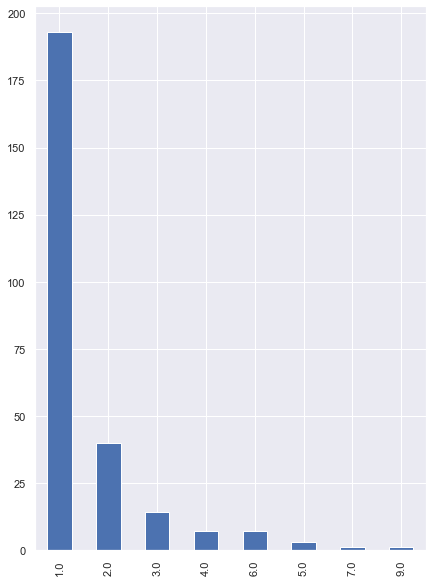

In [173]:
#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure().set_size_inches(7,10)
mdf.donated.value_counts().plot(kind='bar')

**Step 4:** Recode 'donated' column as binary flag equal to 1 if at least one donation was made and 0 otherwise.

In [174]:
mdf['donated'] = [1 if x > 0 else 0 for x in mdf['donated']]
mdf.head()

,account_id,donation_recency,total_donations,donated
0,0011R00001yzm4S,619,1,0
1,0011R00001zaq0m,15,1,0
2,0011R00001zbJO4,439,1,0
3,0011R0000203w1Q,493,1,0
4,0011R000020JELD,595,1,1


In [175]:
#Show the distribution of the target binary flag column ('donated')
mdf.donated.value_counts()

0    1170
1     266
Name: donated, dtype: int64

In [177]:
#Show % distribution of the target flag
mdf.donated.value_counts(normalize=True)

0    0.814763
1    0.185237
Name: donated, dtype: float64

In [178]:
#Another way to do the previous cell
mdf.donated.value_counts()/len(mdf)

0    0.814763
1    0.185237
Name: donated, dtype: float64

In [183]:
#Check the correlations
mdf[mdf.columns[1:].to_list()].corr()

,donation_recency,total_donations,donated
donation_recency,1.000000,-0.235326,-0.259711
total_donations,-0.235326,1.000000,0.330360
donated,-0.259711,0.330360,1.000000


*Because none of the predictors are highly correlated, all of them are 'eligible' for inclusion in the model.*

**Step 5:** Model Building

In [188]:
#SetUp the model
preds = ['donation_recency', 'total_donations']

X = mdf[preds]
y = mdf['donated']

**Split the data into train, test and validation segments (aka 'Tri-Fold Partitioning')**

In [189]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=314)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=.5, random_state=314)

len(X_train), len(X_test), len(X_valid)

(861, 287, 288)

In [190]:
#Show the target distribution in the training set
y_train.value_counts()

0    691
1    170
Name: donated, dtype: int64

In [191]:
#Show the target distribution in the test set
y_test.value_counts()

0    234
1     53
Name: donated, dtype: int64

In [192]:
#Show the target distribution in the validation set
y_valid.value_counts()

0    245
1     43
Name: donated, dtype: int64

In [193]:
from sklearn.linear_model import LogisticRegression

#Define the model object (instantiate the classifier)
clf=LogisticRegression(solver='liblinear', random_state=314)

scores = cross_val_score(clf, X_train, y_train.values.ravel(), scoring='roc_auc', cv=10)
scores.mean()

In [203]:
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, precision_score

In [205]:
#Hyperparameter Tuning
def print_results(results):
    print('BEST PARAMETERS: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_AUC']
    stds = results.cv_results_['std_test_AUC']
    rank = results.cv_results_['rank_test_AUC']
    for mean, std, rank, params in zip(means, stds, rank, results.cv_results_['params']):
        print('{} (+/-{}) {} for {}'.format(round(mean,3),round(std *2,3), rank, params))
        
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [.3, .6, .75],
    }

scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'Precision': 'precision', 'Recall': 'recall'}
clfcv = GridSearchCV(clf, parameters, scoring=scoring, refit='AUC', cv=10)
#Train (fit) the model with the training datasetwhile cross validating 
clfcv.fit(X_train, y_train.values.ravel())

print_results(clfcv)

BEST PARAMETERS: {'C': 0.75, 'penalty': 'l1'}

0.769 (+/-0.133) 5 for {'C': 0.3, 'penalty': 'l1'}
0.769 (+/-0.133) 5 for {'C': 0.3, 'penalty': 'l2'}
0.77 (+/-0.134) 3 for {'C': 0.6, 'penalty': 'l1'}
0.77 (+/-0.134) 3 for {'C': 0.6, 'penalty': 'l2'}
0.77 (+/-0.134) 1 for {'C': 0.75, 'penalty': 'l1'}
0.77 (+/-0.134) 1 for {'C': 0.75, 'penalty': 'l2'}


**Refit model with full training set and both sets of hyperparameters**

In [208]:
LR1 = LogisticRegression(solver='liblinear', C=0.75, penalty='l2', random_state=314)
LR1.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=314, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [209]:
LR2 = LogisticRegression(solver='liblinear', C=0.75, penalty='l1', random_state=314)
LR2.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=314, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
LR3 = LogisticRegression(solver='liblinear', C=0.85, penalty='l2', random_state=314)
LR3.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.85, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=314, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [213]:
for mdl in [LR1, LR2, LR3]:
    y_pred = mdl.predict(X_test)
    AUC = round(roc_auc_score(y_test, y_pred), 3)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred),3)
    print('PENALTY: {} / C: {} -- AUC: {} / A: {} / P: {} / R: {}'. format(mdl.penalty,
                                                                          mdl.C,
                                                                          AUC,
                                                                          accuracy,
                                                                          precision,
                                                                          recall))


PENALTY: l2 / C: 0.75 -- AUC: 0.555 / A: 0.822 / P: 0.583 / R: 0.132
PENALTY: l1 / C: 0.75 -- AUC: 0.555 / A: 0.822 / P: 0.583 / R: 0.132
PENALTY: l2 / C: 0.85 -- AUC: 0.555 / A: 0.822 / P: 0.583 / R: 0.132


In [ ]:
#Make predictions on the test set
preds_test = clf.predict(X_test)

**Step 6:** Model Accuracy

In [195]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds_test)

0.8222996515679443

In [196]:
#Compare model predictions to actual value of the target event (create a confusion matrix)
pd.crosstab(y_test, preds_test)

col_0,0,1
donated,,
0,229,5
1,46,7


**Area under the ROC curve (AUC)**

In [198]:
from sklearn.metrics import roc_auc_score

#Calculate the probabilities on the test sample

scores_test = clf.predict_proba(X_test)[:, 1]

#Calculate AUC
roc_auc_score(y_test, scores_test)

0.7567731011127238

In [199]:
#Score the dataset -- show each donor accounts predicted probability of making a donation in the prediction window

scores_all = clf.predict_proba(mdf[preds])[:,1]

mdf['prob_of_donating'] = scores_all

mdf.head()

,account_id,donation_recency,total_donations,donated,prob_of_donating
0,0011R00001yzm4S,619,1,0,0.077530
1,0011R00001zaq0m,15,1,0,0.222040
2,0011R00001zbJO4,439,1,0,0.107931
3,0011R0000203w1Q,493,1,0,0.097849
4,0011R000020JELD,595,1,1,0.081076


In [202]:
mdf.sort_values('prob_of_donating', ascending = False).reset_index(drop=True)

,account_id,donation_recency,total_donations,donated,prob_of_donating
0,0013600000VKRpL,4,49,1,0.999289
1,0013600000VKQlO,187,47,0,0.998535
2,0013600000VKR7J,0,43,1,0.997968
3,0013600000VKRsl,1,38,1,0.995088
4,0013600000VKQmI,20,36,1,0.992750
...,...,...,...,...,...
1431,0013600000VKRGU,1659,1,0,0.010136
1432,0013600000VKQqB,1660,1,0,0.010115
1433,0013600000YDby6,1793,1,0,0.007747
1434,0013600000VKRZa,1818,1,0,0.007367


# Next, incorporate hyper parameter tuning with the validation set.